# 🛍️ Product Review Sentiment Classifier
### A Beginner's Guide to Text Classification with Machine Learning

---

## 📌 What Are We Building?

We're going to build a model that **reads a product review** and automatically decides:
- ✅ **Good** – The customer liked the product
- ❌ **Bad** – The customer disliked the product  
- 😐 **Neutral** – The customer felt okay about it

This is called **Sentiment Classification** — one of the most common real-world uses of Machine Learning!

---

## 🗺️ Our Roadmap

```
Step 1: Load the Data         → Read our Excel file of reviews
Step 2: Explore the Data      → Understand what we're working with
Step 3: Prepare the Data      → Convert text into numbers (machines love numbers!)
Step 4: Train the Model       → Teach the machine to classify reviews
Step 5: Evaluate the Model    → Check how accurate our model is
Step 6: Predict New Reviews   → Use our model on brand new reviews!
```

---
## 📦 Step 0: Import Libraries

Think of libraries as **toolkits** — someone else built these tools so we don't have to!

| Library | What it does |
|---|---|
| `pandas` | Reads and organizes data (like Excel for Python) |
| `scikit-learn` | Provides machine learning algorithms |
| `matplotlib` | Creates charts and graphs |
| `seaborn` | Makes prettier charts |

In [4]:
# 📦 Import all the tools we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make our plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


---
## 📂 Step 1: Load the Data

We'll load our dataset from the Excel file. The dataset contains **150 product reviews** — 50 Good, 50 Bad, 50 Neutral.

In [6]:
# 📂 Load the Excel dataset
df = pd.read_excel('product_reviews_dataset.xlsx')

print(f'✅ Dataset loaded!')
print(f'📊 Total reviews: {len(df)}')
print(f'📋 Columns: {list(df.columns)}')
print()

# Preview the first 5 rows
print('👀 First 5 rows of our data:')
df.head()

✅ Dataset loaded!
📊 Total reviews: 150
📋 Columns: ['Review', 'Sentiment']

👀 First 5 rows of our data:


,Review,Sentiment
0,Extremely disappointed. Cheaply made and dange...,Bad
1,Wonderful experience from start to finish. Pro...,Good
2,Mediocre product. It gets the job done on a ba...,Neutral
3,Broken on arrival. Packaging was poor and prod...,Bad
4,Faulty product received. Customer service was ...,Bad


---
## 🔍 Step 2: Explore the Data

Before building anything, good data scientists always **understand their data first**.
Let's answer:
- How many reviews of each type do we have?
- What do some sample reviews look like?

In [7]:
# 📊 Count how many reviews of each type we have
print('📊 Count of each sentiment category:')
print(df['Sentiment'].value_counts())
print()

# Calculate percentages
print('📊 Percentage breakdown:')
print(df['Sentiment'].value_counts(normalize=True).map(lambda x: f'{x:.0%}'))

📊 Count of each sentiment category:
Sentiment
Bad        50
Good       50
Neutral    50
Name: count, dtype: int64

📊 Percentage breakdown:
Sentiment
Bad        33%
Good       33%
Neutral    33%
Name: proportion, dtype: object


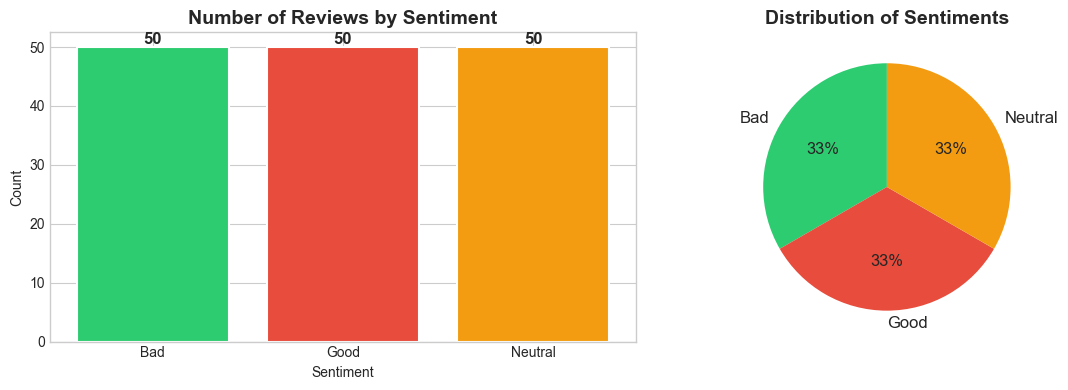


💡 Our dataset is perfectly balanced — equal reviews for each category!


In [8]:
# 📊 Visualize the distribution with a bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green, Red, Orange
counts = df['Sentiment'].value_counts()
axes[0].bar(counts.index, counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Number of Reviews by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for i, (label, val) in enumerate(counts.items()):
    axes[0].text(i, val + 0.5, str(val), ha='center', fontweight='bold', fontsize=12)

# Pie chart
axes[1].pie(counts.values, labels=counts.index, colors=colors,
            autopct='%1.0f%%', startangle=90,
            textprops={'fontsize': 12})
axes[1].set_title('Distribution of Sentiments', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n💡 Our dataset is perfectly balanced — equal reviews for each category!')

In [9]:
# 👀 Look at sample reviews from each category
for sentiment in ['Good', 'Bad', 'Neutral']:
    sample = df[df['Sentiment'] == sentiment]['Review'].iloc[0]
    emoji = {'Good': '✅', 'Bad': '❌', 'Neutral': '😐'}[sentiment]
    print(f'{emoji} {sentiment.upper()} REVIEW EXAMPLE:')
    print(f'   "{sample}"')
    print()

✅ GOOD REVIEW EXAMPLE:
   "Wonderful experience from start to finish. Product is brilliant."

❌ BAD REVIEW EXAMPLE:
   "Extremely disappointed. Cheaply made and dangerous to use."

😐 NEUTRAL REVIEW EXAMPLE:
   "Mediocre product. It gets the job done on a basic level."



📏 Average word count per sentiment:
Sentiment
Bad        9.3
Good       9.2
Neutral    9.8
Name: word_count, dtype: float64


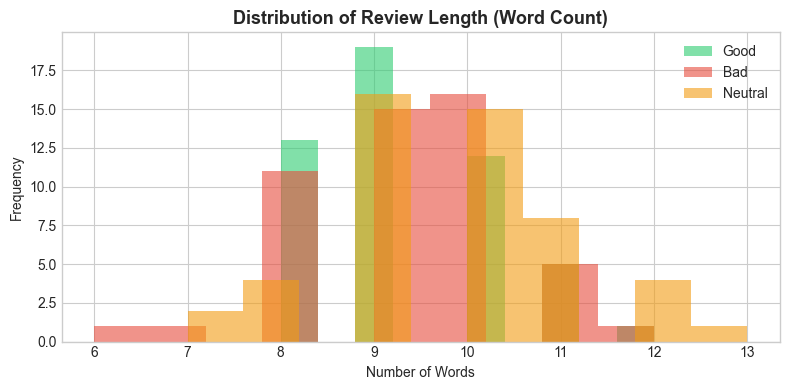

In [10]:
# 📏 Let's see how long our reviews are (word count)
df['word_count'] = df['Review'].str.split().str.len()

print('📏 Average word count per sentiment:')
print(df.groupby('Sentiment')['word_count'].mean().round(1))

plt.figure(figsize=(8, 4))
for i, sentiment in enumerate(['Good', 'Bad', 'Neutral']):
    data = df[df['Sentiment'] == sentiment]['word_count']
    plt.hist(data, alpha=0.6, label=sentiment, color=colors[i], bins=10)
plt.title('Distribution of Review Length (Word Count)', fontsize=13, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

---
## 🔧 Step 3: Prepare the Data

### The Big Challenge: Machines Can't Read Words!

Machine learning models only understand **numbers**. So we need to convert text into numbers.

We'll use a technique called **TF-IDF** (Term Frequency - Inverse Document Frequency).

### What is TF-IDF? 🤔

TF-IDF gives each word a **score** based on:
- **TF (Term Frequency)**: How often does this word appear in this review?
- **IDF (Inverse Document Frequency)**: Is this word unique to some reviews, or does it appear in ALL reviews?

**Example:**
- Word `"the"` → appears in every review → LOW score (not very useful for classification)
- Word `"amazing"` → appears mostly in Good reviews → HIGH score (very useful!)
- Word `"terrible"` → appears mostly in Bad reviews → HIGH score (very useful!)

### 🪓 We also Split the Data into Train and Test sets:
- **Training set (80%)**: The model learns from these examples
- **Test set (20%)**: We use these to check if the model learned correctly (the model has NEVER seen these!)

In [11]:
# 🎯 Separate our input (X) and output (y)
# X = the reviews (what we feed INTO the model)
# y = the sentiment labels (what we want the model to PREDICT)
X = df['Review']
y = df['Sentiment']

print('Input (X) - Reviews:')
print(X[:3].tolist())
print()
print('Output (y) - Labels:')
print(y[:3].tolist())

Input (X) - Reviews:
['Extremely disappointed. Cheaply made and dangerous to use.', 'Wonderful experience from start to finish. Product is brilliant.', 'Mediocre product. It gets the job done on a basic level.']

Output (y) - Labels:
['Bad', 'Good', 'Neutral']


In [12]:
# 🪓 Split data: 80% for training, 20% for testing
# random_state=42 ensures we get the same split every time we run this
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% for testing
    random_state=42,     # Same split every time
    stratify=y           # Ensure equal proportion of each sentiment in both sets
)

print(f'📚 Training set size: {len(X_train)} reviews')
print(f'🧪 Test set size:     {len(X_test)} reviews')
print()
print('Training set breakdown:')
print(y_train.value_counts())
print()
print('Test set breakdown:')
print(y_test.value_counts())

📚 Training set size: 120 reviews
🧪 Test set size:     30 reviews

Training set breakdown:
Sentiment
Bad        40
Neutral    40
Good       40
Name: count, dtype: int64

Test set breakdown:
Sentiment
Bad        10
Neutral    10
Good       10
Name: count, dtype: int64


In [13]:
# 🔢 Convert text to numbers using TF-IDF
# ngram_range=(1,2) means we consider single words AND pairs of words
# e.g., "not good" should be treated as a pair, not just "not" and "good" separately
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),   # Consider single words and word pairs
    min_df=1,             # Include words that appear at least once
    max_features=5000     # Keep only the 5000 most important word features
)

# 🏋️ "Fit" on training data: the vectorizer learns which words exist
# Then "transform" converts reviews into numbers
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)  # Only transform (not fit!) the test data

print(f'✅ Text converted to numbers!')
print(f'📐 Shape of training data: {X_train_tfidf.shape}')
print(f'   → {X_train_tfidf.shape[0]} reviews × {X_train_tfidf.shape[1]} word features')
print()
print('Sample of learned vocabulary (first 20 words):')
vocab = vectorizer.get_feature_names_out()
print(list(vocab[:20]))

✅ Text converted to numbers!
📐 Shape of training data: (120, 1135)
   → 120 reviews × 1135 word features

Sample of learned vocabulary (first 20 words):
['10', '10 out', '10 this', 'about', 'about but', 'about it', 'about okay', 'about the', 'absolute', 'absolute rubbish', 'absolutely', 'absolutely delighted', 'absolutely disgusted', 'absolutely love', 'absolutely shocking', 'acceptable', 'acceptable for', 'add', 'add really', 'adequate']


---
## 🤖 Step 4: Train the Model

We'll use **Logistic Regression** — a simple but powerful algorithm for classification.

### How does Logistic Regression work? 🤔

Imagine the model looks for **signals in the words**:
- Words like *"amazing", "perfect", "love"* → strong signal for **Good**
- Words like *"terrible", "broken", "awful"* → strong signal for **Bad**
- Words like *"okay", "average", "decent"* → signal for **Neutral**

The model learns the **weight** (importance) of each word from the training data, then uses those weights to classify new reviews!

In [14]:
# 🤖 Create and train the Logistic Regression model
model = LogisticRegression(
    max_iter=1000,      # Max number of training iterations
    random_state=42,    # For reproducibility
    C=1.0               # Controls how complex the model can get
)

# 🏋️ TRAIN the model on our training data!
# This is where the magic happens — the model learns from examples
model.fit(X_train_tfidf, y_train)

print('✅ Model trained successfully!')
print()
print('📚 The model has learned from:')
print(f'   - {len(X_train)} product reviews')
print(f'   - {X_train_tfidf.shape[1]} word features')
print(f'   - 3 sentiment categories: Good, Bad, Neutral')

✅ Model trained successfully!

📚 The model has learned from:
   - 120 product reviews
   - 1135 word features
   - 3 sentiment categories: Good, Bad, Neutral


In [15]:
# 🔍 Let's see which words the model considers most important!
feature_names = vectorizer.get_feature_names_out()
classes = model.classes_

print('🔑 TOP 10 MOST IMPORTANT WORDS FOR EACH SENTIMENT:\n')

for i, class_name in enumerate(classes):
    # Get the coefficient (weight) for each word for this class
    coef = model.coef_[i]
    # Get indices of top 10 words
    top_indices = coef.argsort()[-10:][::-1]
    top_words = [(feature_names[j], round(coef[j], 3)) for j in top_indices]
    
    emoji = {'Good': '✅', 'Bad': '❌', 'Neutral': '😐'}[class_name]
    print(f'{emoji} {class_name.upper()} reviews — key words:')
    for word, weight in top_words:
        bar = '█' * int(weight * 5)
        print(f'   {word:<20} {bar}')
    print()

🔑 TOP 10 MOST IMPORTANT WORDS FOR EACH SENTIMENT:

❌ BAD reviews — key words:
   broke                ███
   useless              █
   made                 █
   immediately          █
   worst                █
   bad                  █
   broken               █
   terrible             █
   at all               █
   money                █

✅ GOOD reviews — key words:
   and                  ██
   fantastic            ██
   quality and          ██
   the quality          ██
   fast                 ██
   great                ██
   highly               ██
   with                 ██
   everything           ██
   impressed            ██

😐 NEUTRAL reviews — key words:
   but                  █████
   it                   ████
   okay                 ██
   for                  ██
   nothing              ██
   average              ██
   fine                 ██
   functional           ██
   works                ██
   does                 ██



---
## 📊 Step 5: Evaluate the Model

Now we test our model on the **test set** — data it has never seen before!

### Key Metrics:
- **Accuracy**: Overall % of correct predictions
- **Precision**: Of all reviews predicted as "Good", what % were actually Good?
- **Recall**: Of all actual "Good" reviews, what % did we correctly identify?
- **F1-Score**: A balance between Precision and Recall
- **Confusion Matrix**: A grid showing where the model got confused

In [16]:
# 🎯 Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# 📊 Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

print('=' * 50)
print(f'🎯 OVERALL ACCURACY: {accuracy:.1%}')
print('=' * 50)
print()

if accuracy >= 0.85:
    print('🏆 Excellent! The model achieved 85%+ accuracy!')
elif accuracy >= 0.75:
    print('👍 Good performance! The model is working well.')
else:
    print('🔄 The model needs improvement.')

print()
print('📊 Detailed Performance Report:')
print(classification_report(y_test, y_pred))

🎯 OVERALL ACCURACY: 90.0%

🏆 Excellent! The model achieved 85%+ accuracy!

📊 Detailed Performance Report:
              precision    recall  f1-score   support

         Bad       0.89      0.80      0.84        10
        Good       0.90      0.90      0.90        10
     Neutral       0.91      1.00      0.95        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



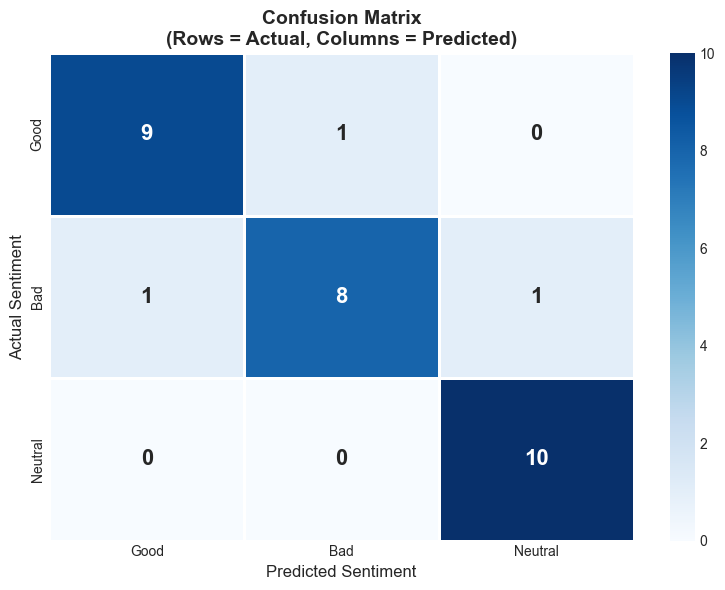


📖 How to read this:
  ✅ Diagonal cells (top-left to bottom-right) = CORRECT predictions
  ❌ Off-diagonal cells = MISTAKES (model confused one category for another)


In [17]:
# 🗺️ Confusion Matrix — shows where the model gets confused
# Rows = Actual labels, Columns = Predicted labels
# Perfect model would have all values on the diagonal!

cm = confusion_matrix(y_test, y_pred, labels=['Good', 'Bad', 'Neutral'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Good', 'Bad', 'Neutral'],
    yticklabels=['Good', 'Bad', 'Neutral'],
    linewidths=2,
    linecolor='white',
    annot_kws={'size': 16, 'weight': 'bold'}
)
plt.title('Confusion Matrix\n(Rows = Actual, Columns = Predicted)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Sentiment', fontsize=12)
plt.xlabel('Predicted Sentiment', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n📖 How to read this:')
print('  ✅ Diagonal cells (top-left to bottom-right) = CORRECT predictions')
print('  ❌ Off-diagonal cells = MISTAKES (model confused one category for another)')

C:\Users\singazq\AppData\Local\Temp\ipykernel_24236\3166097247.py:28: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\singazq\AppData\Local\Temp\ipykernel_24236\3166097247.py:28: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\singazq\AppData\Local\Temp\ipykernel_24236\3166097247.py:29: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig('accuracy_results.png', dpi=150, bbox_inches='tight')
C:\Users\singazq\AppData\Local\Temp\ipykernel_24236\3166097247.py:29: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.savefig('accuracy_results.png', dpi=150, bbox_inches='tight')
C:\Users\singazq\AppData\Local\miniconda3\envs\env_gemini\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\

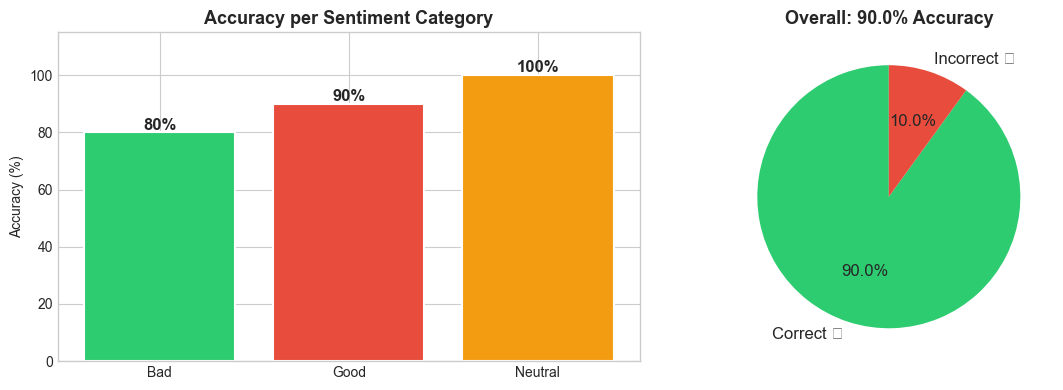

In [18]:
# 📊 Visualize actual vs predicted results
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy per category
accuracy_per_class = results_df.groupby('Actual')['Correct'].mean()
bars = axes[0].bar(accuracy_per_class.index, accuracy_per_class.values * 100,
                   color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Accuracy per Sentiment Category', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(0, 115)
for bar, val in zip(bars, accuracy_per_class.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{val:.0%}', ha='center', fontweight='bold', fontsize=12)

# Correct vs Incorrect
correct_counts = results_df['Correct'].value_counts()
axes[1].pie([correct_counts.get(True, 0), correct_counts.get(False, 0)],
            labels=['Correct ✅', 'Incorrect ❌'],
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 12})
axes[1].set_title(f'Overall: {accuracy:.1%} Accuracy', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_results.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 🔮 Step 6: Predict New Reviews!

Our model is trained and evaluated. Now let's use it to classify **brand new reviews** that weren't in our dataset!

In [19]:
# 🔮 Predict sentiment for new, unseen reviews
def predict_sentiment(reviews):
    """Takes a list of review strings and returns predicted sentiments with confidence."""
    # Convert text to TF-IDF numbers using the SAME vectorizer we trained
    reviews_tfidf = vectorizer.transform(reviews)
    
    # Get predictions
    predictions = model.predict(reviews_tfidf)
    
    # Get confidence scores (probability for each class)
    probabilities = model.predict_proba(reviews_tfidf)
    confidence = probabilities.max(axis=1)
    
    return predictions, confidence

# 📝 Try it with some new reviews!
new_reviews = [
    "This product is absolutely wonderful! Best purchase I've made this year.",
    "Complete garbage. Broke after one use. Total waste of money.",
    "It's okay I guess. Nothing special, just does the job.",
    "Very impressive quality. Highly recommend to anyone!",
    "Disappointed with this product. Not as described at all.",
    "Arrived on time. Works as expected. Nothing more to say."
]

predictions, confidences = predict_sentiment(new_reviews)

emoji_map = {'Good': '✅', 'Bad': '❌', 'Neutral': '😐'}

print('🔮 PREDICTIONS FOR NEW REVIEWS:')
print('=' * 70)
for review, pred, conf in zip(new_reviews, predictions, confidences):
    emoji = emoji_map[pred]
    print(f'{emoji} Prediction: {pred:<8} | Confidence: {conf:.1%}')
    print(f'   Review: "{review}"')
    print()

🔮 PREDICTIONS FOR NEW REVIEWS:
✅ Prediction: Good     | Confidence: 49.7%
   Review: "This product is absolutely wonderful! Best purchase I've made this year."

❌ Prediction: Bad      | Confidence: 61.4%
   Review: "Complete garbage. Broke after one use. Total waste of money."

😐 Prediction: Neutral  | Confidence: 65.9%
   Review: "It's okay I guess. Nothing special, just does the job."

✅ Prediction: Good     | Confidence: 46.5%
   Review: "Very impressive quality. Highly recommend to anyone!"

❌ Prediction: Bad      | Confidence: 42.6%
   Review: "Disappointed with this product. Not as described at all."

😐 Prediction: Neutral  | Confidence: 55.5%
   Review: "Arrived on time. Works as expected. Nothing more to say."



In [20]:
# 🎮 Interactive Prediction — try your own review!
def classify_my_review(review_text):
    """Classify a single review and show detailed results."""
    preds, confs = predict_sentiment([review_text])
    pred = preds[0]
    conf = confs[0]
    
    # Get probabilities for all classes
    review_tfidf = vectorizer.transform([review_text])
    all_probs = model.predict_proba(review_tfidf)[0]
    
    emoji = emoji_map[pred]
    print(f'Review: "{review_text}"')
    print()
    print(f'  {emoji} Prediction: {pred} (Confidence: {conf:.1%})')
    print()
    print('  Probability breakdown:')
    for cls, prob in zip(model.classes_, all_probs):
        bar = '█' * int(prob * 30)
        print(f'    {cls:<8}: {bar} {prob:.1%}')

# ✏️ Change this review to test your own!
my_review = "The product quality is superb and it arrived quickly. Very happy!"
classify_my_review(my_review)

Review: "The product quality is superb and it arrived quickly. Very happy!"

  ✅ Prediction: Good (Confidence: 52.9%)

  Probability breakdown:
    Bad     : ████████ 27.5%
    Good    : ███████████████ 52.9%
    Neutral : █████ 19.6%


In [21]:
# 🧪 Try another review — edit this text!
my_review_2 = "It's okay, nothing special. Does what it's supposed to do."
classify_my_review(my_review_2)

Review: "It's okay, nothing special. Does what it's supposed to do."

  😐 Prediction: Neutral (Confidence: 65.2%)

  Probability breakdown:
    Bad     : █████ 19.2%
    Good    : ████ 15.6%
    Neutral : ███████████████████ 65.2%


---
## 📋 Step 7: Summary & Results

Let's wrap up everything we did!

In [22]:
# 📋 Print a clean summary
print('=' * 60)
print('📋  PROJECT SUMMARY')
print('=' * 60)
print()
print('🎯 GOAL:')
print('   Classify product reviews as Good, Bad, or Neutral')
print()
print('📊 DATASET:')
print(f'   Total reviews: {len(df)}')
print(f'   Good: 50 | Bad: 50 | Neutral: 50 (balanced!)')
print(f'   Training set: {len(X_train)} reviews (80%)')
print(f'   Test set:     {len(X_test)} reviews (20%)')
print()
print('🔧 TECHNIQUE:')
print('   Text conversion: TF-IDF Vectorizer')
print('   Algorithm:       Logistic Regression')
print()
print('📈 RESULTS:')
print(f'   ✅ Overall Accuracy: {accuracy:.1%}')
if accuracy >= 0.85:
    print('   🏆 Goal achieved! (Target was 85%+)')
print()
print('💡 KEY LEARNINGS:')
print('   1. Text must be converted to numbers for ML models')
print('   2. TF-IDF weights words by their importance')
print('   3. Logistic Regression is great for text classification')
print('   4. Always split data into train and test sets')
print('   5. Evaluate on data the model has NEVER seen')
print()
print('=' * 60)

📋  PROJECT SUMMARY

🎯 GOAL:
   Classify product reviews as Good, Bad, or Neutral

📊 DATASET:
   Total reviews: 150
   Good: 50 | Bad: 50 | Neutral: 50 (balanced!)
   Training set: 120 reviews (80%)
   Test set:     30 reviews (20%)

🔧 TECHNIQUE:
   Text conversion: TF-IDF Vectorizer
   Algorithm:       Logistic Regression

📈 RESULTS:
   ✅ Overall Accuracy: 90.0%
   🏆 Goal achieved! (Target was 85%+)

💡 KEY LEARNINGS:
   1. Text must be converted to numbers for ML models
   2. TF-IDF weights words by their importance
   3. Logistic Regression is great for text classification
   4. Always split data into train and test sets
   5. Evaluate on data the model has NEVER seen



---
## 🎓 What's Next?

Now that you've built your first classifier, here are some things you could explore next:

| 🚀 Next Step | Description |
|---|---|
| **More Data** | Add more reviews to improve accuracy |
| **Other Algorithms** | Try Random Forest, SVM, or Neural Networks |
| **Deep Learning** | Use BERT or transformers for state-of-the-art results |
| **Real Data** | Scrape real Amazon or Yelp reviews |
| **Deploy** | Build a web app that classifies reviews in real time |

---
### 🙌 Congratulations on building your first Text Classifier!

You've just used the same fundamental techniques that power:
- Spam email detection 📧
- Social media sentiment analysis 📱
- Customer feedback systems 🏢
- News article categorization 📰